In [27]:
import sympy
from sympy import I, re, im
from sympy.parsing.sympy_parser import (parse_expr, standard_transformations,
                                        implicit_multiplication_application,convert_xor)
from IPython.display import display
sympy.init_printing(use_latex='mathjax')
import numpy as np
np.set_printoptions(suppress=True)
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, generate_preset_pass_manager, transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from sympy.functions.special.polynomials import chebyshevt
from scipy.optimize import minimize


In [4]:
try:
    # Input
    func_str = input("Enter the function to integrate (e.g., sin(x) * exp(-x)): ")
    lower_limit_str = input("Enter the lower limit of integration (e.g., 0): ")
    upper_limit_str = input("Enter the upper limit of integration (e.g., pi): ")

    # Define the symbols
    x = sympy.symbols('x', real=True)
    expected_symbols = {x}

    # Parse the Function String
    local_dict = {'x': x}
    global_dict = sympy.__dict__
    transformations = standard_transformations + (implicit_multiplication_application, convert_xor)
    func_expr = parse_expr(func_str,
                           local_dict=local_dict,
                           global_dict=global_dict,
                           transformations=transformations)

    # VALIDATE
    found_symbols = func_expr.free_symbols
    if not found_symbols.issubset(expected_symbols):
        unknown_symbols = found_symbols - expected_symbols
        raise ValueError(f"Function contains unknown variables: {unknown_symbols}. "
                         f"The expression must only depend on 'x'.")

    # --- Finalize Inputs ---
    lower_limit = sympy.sympify(lower_limit_str)
    upper_limit = sympy.sympify(upper_limit_str)

    func = sympy.simplify(func_expr)
    
    # --- Display the problem ---
    integral_expr = sympy.Integral(func, (x, lower_limit, upper_limit))
    print("\nEntered definite integral Mathematical expression:")
    display(integral_expr)

    # Convert limits to floats to prevent constants parsing errors
    try:
        lower_limit_f = float(lower_limit)
        upper_limit_f = float(upper_limit)
    except TypeError:
        lower_limit_f = float(lower_limit.evalf())
        upper_limit_f = float(upper_limit.evalf())

    lower_limit=lower_limit_f
    upper_limit= upper_limit_f
except Exception as e:
    print(f"\nError: Could not process the input. Please check the expression. \nDetails: {e}")






Entered definite integral Mathematical expression:


10          
⌠           
⎮  log(x) dx
⌡           
1           

In [ ]:
def getChebyshevPolynomial( sympy_symbol,sympy_func ,degree, lower_limit, upper_limit):
    """
    Generates a high-quality Chebyshev polynomial approximation for a given SymPy function
    using NumPy's fitting method.
    This is the ideal method because Taylor's approximation requires O(d^2) oracle calls.
    Chebyshev approximation also uniformly distributes the error in the range making it ideal for this scenario.
    """
    print(f"Chebyshev Approximation to {degree}th degree:\n")

    # 1. Callable numerical version of the function "Oracle"
    f_numeric = sympy.lambdify(sympy_symbol, sympy_func, 'numpy')

    # 2. Define the coordinate transformation from [lower_limit, upper_limit] to [-1, 1]
    jac_scaling = (upper_limit - lower_limit) / 2.0
    offset = (upper_limit + lower_limit) / 2.0
    
    # This is f(x) re-parameterized in terms of y. This is the function we will approximate.
    func_to_approximate = lambda y_val: f_numeric(jac_scaling * y_val + offset)

    # 3. Generate sample points and query the oracle to get data for fitting
    # For a degree `d` polynomial, we need at least `d+1` points. 2*degree is ideal
    num_samples = 2 * degree
    sample_points_y = np.linspace(-1, 1, num_samples)
    sample_values_f = func_to_approximate(sample_points_y)

    # 4. Use NumPy to fit the Chebyshev polynomial to the sampled data
    cheb_poly_fit = np.polynomial.chebyshev.Chebyshev.fit(
        sample_points_y,
        sample_values_f,
        deg=degree
    )
    
    # The coefficients are ordered from T_0 to T_d
    coeffs = cheb_poly_fit.convert().coef
    print(f"Found {len(coeffs)} coefficients.")

    # 5. Calculate the scaling factor M = 4 * max(|f(x)|)
    # We find the max value by evaluating our new high-quality approximation on a fine grid.
    fine_grid_y = np.linspace(-1, 1, 1000)
    max_f_val = np.max(np.abs(cheb_poly_fit(fine_grid_y)))
    M = 4.0 * max_f_val
    print(f"M value for scaling is: {M:.4f}")

    # 6. Reconstruct a SymPy expression for display and symbolic integration
    # The polynomial for the integral must approximate g(y) = f(x) * jac_scaling
    y_sym = sympy.Symbol('y')
    chebyshev_sympy_f = sum(coeffs[i] * chebyshevt(i, y_sym) for i in range(len(coeffs)))
    chebyshev_sympy_g = jac_scaling * chebyshev_sympy_f

    integration_expr = sympy.Integral(chebyshev_sympy_g, (y_sym, -1, 1))
    print("\nApproximated Integral (Chebyshev Polynomial on [-1, 1]):")
    display(integration_expr)
    
    # 7. New: Explicitly check the endpoint error to verify the quality
    true_val_at_endpoint = func_to_approximate(1.0) # This is f(upper_limit)
    approx_val_at_endpoint = cheb_poly_fit(1.0)
    abs_error = np.abs(true_val_at_endpoint - approx_val_at_endpoint)
    
    print(f"\nError analysis at endpoint y=1 (x={upper_limit}):")
    print(f"  - True value of f({upper_limit}) = {true_val_at_endpoint:.8f}")
    print(f"  - Approx value from poly = {approx_val_at_endpoint:.8f}")
    print(f"  - Absolute Error = {abs_error:.2e}")

    return coeffs, M, chebyshev_sympy_g

In [6]:
# Discretize func_expr
def discretize(f_callable,lower_limit, upper_limit,N):
    upper_limit= float(upper_limit)
    lower_limit= float(lower_limit)
    
    #f_callable= sympy.lambdify(x, func, 'numpy')

    # N random X points such that there are N random F(x). Sigma F(x) deltaX is integral (RIEMANN SUM)
    x_array = np.random.uniform(lower_limit,upper_limit,N)
    y_array= f_callable(x_array)
   
    return y_array,x_array 

In [40]:
# Degree of Approximation
d= 14
num_qubits=13
N=2**num_qubits

In [ ]:
# Plot an unscaled approximated polyomial to show that the approximated graph is very close to the original.
# Also Plot the |f(x)-P(x)| graph to show that the error is uniformly distributed.
### NOTE: Here g(y) is returned. g(y)= f(x)* jac_scaling.  f(x)= g(y)/jac_scaling..
#  jac_scaling=(upper-lower)/2
temp_coeff,tempM,Approx_chebyshev_Polynomial= getChebyshevPolynomial(x,func, d, lower_limit, upper_limit)


NumPy Chebyshev Approximation to 14th degree:

Found 15 coefficients.
M value for scaling is: 9.2103

Approximated Integral (Chebyshev Polynomial on [-1, 1]):


1                                                                              ↪
⌠                                                                              ↪
⎮  ⎛                     14                      13                      12    ↪
⎮  ⎝- 0.406087521656328⋅y   + 0.450717275583798⋅y   + 0.859587875031073⋅y   -  ↪
⌡                                                                              ↪
-1                                                                             ↪

↪                                                                              ↪
↪                                                                              ↪
↪                    11                      10                      9         ↪
↪ 0.863426802729931⋅y   - 0.924089101579893⋅y   + 0.880558375349223⋅y  + 0.310 ↪
↪                                                                              ↪
↪                                                                              ↪

↪                         


Error analysis at endpoint y=1 (x=10.0):
  - True value of f(10.0) = 2.30258509
  - Approx value from poly = 2.30258498
  - Absolute Error = 1.09e-07


In [50]:
# Create a numerical version of the original function f(x).
f_numerical = sympy.lambdify(x, func, 'numpy')
jac_scaling = (upper_limit - lower_limit) / 2.0
offset = (upper_limit + lower_limit) / 2.0
f_ideal_callable = lambda y: f_numerical(jac_scaling * y + offset)

y,x_array= discretize(f_ideal_callable,-1,1,2**14)


g_numerical = sympy.lambdify(sympy.symbols('y',real=True),
                              Approx_chebyshev_Polynomial, 'numpy')

# gy_classical= f(x)/jac_scaling
y_classical= g_numerical(x_array)/((upper_limit-lower_limit)/2)

In [51]:
def IntegrateClassical(y_classical,lower_limit,upper_limit,N):

    total_sum= np.sum(y_classical, dtype= float)

    # Average
    answer=(total_sum/N)*(upper_limit-lower_limit)

    print("Y Classical Array:")
    print(y_classical)


    print("\nClassical Integration Answer:")
    print(answer)
    return

IntegrateClassical(y_classical,-1,1,N)

print(y)

Y Classical Array:
[2.12821208 1.81230064 0.43011727 ... 2.06984304 1.29980807 1.43236036]

Classical Integration Answer:
6.2126563175317235
[2.12821445 1.81229928 0.43010566 ... 2.06984268 1.29980796 1.43235763]


The Original Function F_callable is assumed to be the ideal in 2^14 samples to show almost continuous function plot.
This is because present QPUs can't run this algorithm for 14 qubits and the simulation is quite resource intensive.

Chebyshev_polynomial_expr is the approximated chebyshev polynomial from the original f(x)
    This polynomial is approximated to the dth degree and N= 2**n samples.
    The plots of this polynomial are in Green Color.


Quantum Loaded Plots are in Blue Color.
 


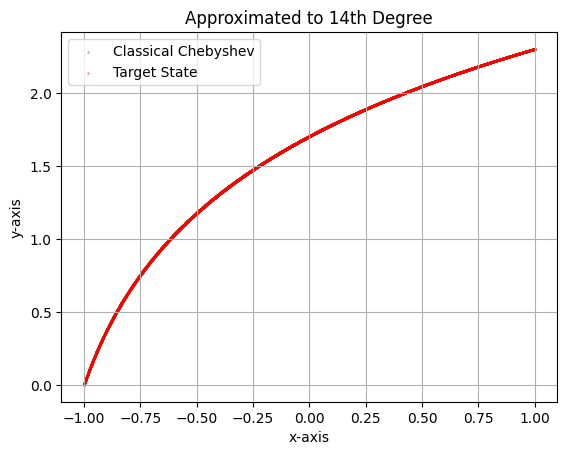

In [52]:
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.title(f"Approximated to {d}th Degree")
plt.scatter(x_array,y_classical,
             color='green', label='Classical Chebyshev',s=0.1)
plt.scatter(x_array,y,
            color='red',label='Target State', s=0.1)
plt.grid(True)
plt.legend()
plt.show()

In [47]:
print(g_numerical(1))

print(f_numerical(10))

10.361632428839611
2.302585092994046


In [ ]:
plt.xlabel("x-axis")
plt.ylabel("y-axis")

plt.title(f"Error of{d}th Degree")



In [ ]:
chebyshev_coeffs, M,chebyshev_Polynomial = getChebyshevPolynomial(x,func, d, lower_limit, upper_limit,0.25)

print(f"The Chebyshev polynomial {len(chebyshev_coeffs)} coefficients to encode on Quantum Circuit are: ")
print(chebyshev_coeffs)


Chebyshev APPROXIMATION to 14th degree : 
[PolyTaylorSeries] (Cheb) max 0.39086585847364935 is at 1.0: normalizing
[PolyTaylorSeries] (Cheb) average error = 1.8345456924041132e-06 in the domain [-1, 1] using degree 14
M value for scaling is: 9.2103

Approximated Integral (Chebyshev Polynomial on [-1, 1]):


1                                                                              ↪
⌠                                                                              ↪
⎮  ⎛                     14                     13                      12     ↪
⎮  ⎝- 0.214613945739972⋅y   + 0.22244990000608⋅y   + 0.519204398914016⋅y   - 0 ↪
⌡                                                                              ↪
-1                                                                             ↪

↪                                                                              ↪
↪                                                                              ↪
↪                   11                      10                      9          ↪
↪ .479426794209871⋅y   - 0.594832846745593⋅y   + 0.509715120669933⋅y  + 0.2674 ↪
↪                                                                              ↪
↪                                                                              ↪

↪                         

The Chebyshev polynomial 15 coefficients to encode on Quantum Circuit are: 
[ 0.5729431   0.40610482 -0.10548448  0.03653236 -0.01423375  0.00591548
 -0.00256088  0.00114031 -0.00051834  0.00023935 -0.00011191  0.00005285
 -0.00002517  0.00001207 -0.00000582]


In [ ]:
def walsh_loader(qc,Qbit,ancilla,y,N):
    # Min-Max scale y
    y= y
    wh_transform=np.array(sympy.fwht(y), dtype=float)/np.sqrt(N)

    
    print("THIS IS Y L2 NORMALIZED")
    print(y)

    print("THIS IS AFTER APPLYING FWHT")
    print(wh_transform)

    return qc

In [ ]:
Qbit= QuantumRegister(num_qubits,name='logical')
Cbit= ClassicalRegister(num_qubits,name='result')
ancilla= QuantumRegister(3,name='anc')

qc= QuantumCircuit(Qbit,ancilla,Cbit)
#Equal Superposition


#qc= walsh_loader(qc,Qbit,ancilla,,N)

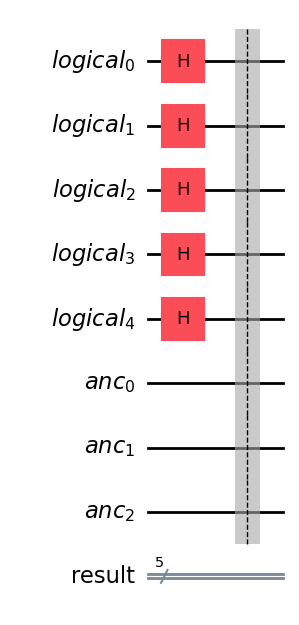

In [86]:
qc.draw('mpl')

In [ ]:
service = QiskitRuntimeService(name="qiskit_adi")
# Get a backend
backend = AerSimulator()
#backend = service.least_busy(operational=True, simulator=False)
#backend= service.backend(name='ibm_torino')
print(f"We are using the {backend.name} quantum computer")
shots= 1024
sampler = Sampler(mode=backend)